In [1]:
import numpy as np
import cv2
from pathlib import Path
import os
import glob
import h5py
from keras import __version__ as keras_version
from typing import List

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:

def load_vehicle_states(dir: Path, regex="/*.npy") -> np.ndarray:
    file_paths = sorted(glob.glob((dir.as_posix() + regex)), key=os.path.getmtime)
    states = []
    for fpath in file_paths:
        state = np.load(fpath, allow_pickle=True)
        states.append(state)
    return np.array(states)


def load_images(image_dir: Path, regex="/*.png") -> List:
    file_paths = sorted(glob.glob((image_dir.as_posix() + regex)), key=os.path.getmtime)
    images = []
    for fpath in file_paths:
        image = cv2.imread(fpath)
        images.append(image)
    return images


def load_depth_images(dir, regex="/*.npy") -> List:
    file_paths = sorted(glob.glob((dir.as_posix() + regex)), key=os.path.getmtime)
    images = []
    for fpath in file_paths:
        image = np.load(fpath)
        images.append(image)
    return images


def load_data():
    rgb_images = load_images(Path("../data/output/front_rgb/"), regex="/frame_*")
    vehicle_states = load_vehicle_states(dir=Path("../data/output/vehicle_state"))
    # depth_images = load_depth_images(dir=Path("../data/output/front_depth"))
    X = rgb_images
    y = np.array(vehicle_states)[:, -1]

    return X, y


def plot_steering_hist(steerings: np.ndarray):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.grid(True)
    ax.set(title="Ensemble - Distribution of steering angles")
    count, bins, _ = ax.hist(steerings, bins=25, histtype='bar')
    plt.show()


def fliph_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)


def blur_image(img, f_size=5):
    """
    Applies Gaussir Blur to smoothen the image.
    This in effect performs anti-aliasing on the provided image
    """
    img = cv2.GaussianBlur(img, (f_size, f_size), 0)
    img = np.clip(img, 0, 255)

    return img.astype(np.uint8)


def translate_image(img, st_angle, low_x_range, high_x_range, low_y_range, high_y_range, delta_st_angle_per_px):
    """
    Shifts the image right, left, up or down.
    When performing a lateral shift, a delta proportional to the pixel shifts is added to the current steering angle
    """
    rows, cols = (img.shape[0], img.shape[1])
    translation_x = np.random.randint(low_x_range, high_x_range)
    translation_y = np.random.randint(low_y_range, high_y_range)

    st_angle += translation_x * delta_st_angle_per_px

    translation_matrix = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))

    return img, st_angle


def change_image_lightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'L' component of the supplied image in HSL format
    The returned image in converted back to RGB
    """
    # Convert to HSL (HLS in OpenCV!!)
    hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
    hls = hls.astype(int)

    # Add an offset to light component
    offset = np.random.randint(low, high=high)
    # Since the format is HLS and NOT HSL, it is the second component (index 1) that is modified
    # hls[:,:,1] += offset
    hls[:, :, 1] = offset

    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hls, 0, 255)

    # Convert back to uint
    hls = hls.astype(np.uint8)

    # Make sure we return image in RGB format
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def change_image_brightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'V' component of the supplied image in HSV format
    The returned image in converted back to RGB
    """

    # Convert to HSV
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv = hsv.astype(int)

    # Adding the offset to the v component
    offset = np.random.randint(low, high=high)
    hsv[:, :, 2] += offset

    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hsv, 0, 255)

    # Convert back to uint
    hsv = hsv.astype(np.uint8)

    # Make sure we return image in RGB format
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow poligon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])

    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)

    poly = np.asarray([[[top_y, 0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right, 0]]], dtype=np.int32)

    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight

    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    # masked_image = cv2.bitwise_and(img, mask)

    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)


def shift_horizon(img, h_s=0.2):
    img = img.astype(np.float32)

    # randomly shift horizon
    height = img.shape[0]
    width = img.shape[1]
    horizon = h_s * height / 3
    v_shift = np.random.randint(-height / 8, height / 8)
    pts1 = np.float32([[0, horizon], [width, horizon], [0, height], [width, height]])
    pts2 = np.float32([[0, horizon + v_shift], [width, horizon + v_shift], [0, height], [width, height]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M, (width, height), borderMode=cv2.BORDER_REPLICATE)

    return img.astype(np.uint8)


def change_image_brightness_rgb(img, s_low=0.2, s_high=0.75):
    """
    Changes the image brightness by multiplying all RGB values by the same scalacar in [s_low, s_high).
    Returns the brightness adjusted image in RGB format.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:, :, :] *= s
    np.clip(img, 0, 255)
    return img.astype(np.uint8)


def augment_image(img, st_angle, p=1.0):
    """
    Augment a given image, by applying a series of transformations, with a probability p.
    The steering angle may also be modified.
    Returns the tuple (augmented_image, new_steering_angle)
    """
    aug_img = img

    # if np.random.random_sample() <= 1.0:
    # Reduce aliasing via blurring
    # aug_img = blur_image(aug_img)

    if np.random.random_sample() <= 0.5:
        # Horizontally flip image
        aug_img = fliph_image(aug_img)
        st_angle = -st_angle

    if np.random.random_sample() <= 0.5:
        aug_img = change_image_brightness_rgb(aug_img)

    if np.random.random_sample() <= 0.5:
        aug_img = add_random_shadow(aug_img, w_low=0.45)

    if np.random.random_sample() <= 0.5:
        # Shift the image left/right, up/down and modify the steering angle accordingly
        aug_img, st_angle = translate_image(aug_img, st_angle, -60, 61, -20, 21, 0.35 / 100.0)
    return aug_img, st_angle


def generate_images(X, y, batch_size, shuffle=True, aug_likelihood=0.5, data_aug_pct=0.8):
    num_images, width, height, channel = np.shape(X)
    assert num_images == len(y), f"Dimension mismatch: Got {num_images} X but {len(y)} y"
    batch = np.zeros((batch_size, width, height, channel), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    while True:
        k = 0
        while k < batch_size:
            idx = np.random.randint(0, num_images)
            image = X[idx]
            steering_angle = y[idx]
            img, st_angle = None, None
            if np.random.random_sample() <= data_aug_pct:
                img, st_angle = augment_image(img=image, st_angle=steering_angle, p=aug_likelihood)
            else:
                img, st_angle = image, steering_angle
            batch[k] = img / 255.0 # normalize image
            steering_angles[k] = st_angle
            k += 1
        yield batch, np.clip(steering_angles, -1, 1)


def show_images(imgs, labels, cols=5, fig_size=(15, 5)):
    rows = len(imgs) // cols
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            img = imgs[cols * r + c] * 255
            lb = labels[cols * r + c]
            ax.imshow(img.astype(np.uint8))
            ax.axis('on')
            ax.set_aspect('equal')
            ax.set(title=lb)
    fig.tight_layout()
    plt.show()


def show_sample_images(X, y):
    gen = generate_images(X=X, y=y, batch_size=20)
    b, s = next(gen)
    show_images(b[0:20], s[0:20])


def plot_results(hist, metrics, xlb, ylb, title, leg, fsize=(10, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    for m in metrics:
        ax.plot(hist.history[m])

    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.set_yscale('log')

    ax.legend(leg, loc='upper left')
    plt.show()

def generate_train_test_split(X, y, test_size): 
    return train_test_split(X, y, test_size=test_size)

In [4]:
X, y = load_data()
X_train, X_test, y_train, y_test = generate_train_test_split(X, y, test_size=0.33)

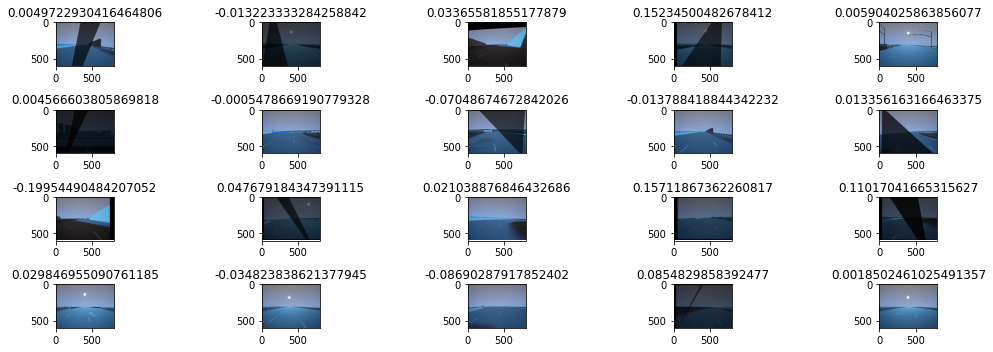

In [17]:
show_sample_images(X_train, y_train)

In [9]:
from model import nvidia_model
m = nvidia_model()
# m.summary()

In [10]:
batch_size = 16
gen = generate_images(X_train, y_train, batch_size)

In [11]:
class CustomEarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(CustomEarlyStoppingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        if loss < self.threshold:
            print("Stopping early!")
            self.model.stop_training = True
        else:
            print("HERE")

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss', min_delta=0.1, patience=1, verbose=1, mode="min", baseline=0.4
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "nvidia_model.h5", monitor="loss", save_best_only=True
    )
#     tf.keras.callbacks.TensorBoard(
#         log_dir='logs', histogram_freq=1, write_graph=True,
#         write_images=True, update_freq=1000, profile_batch=2,
#         embeddings_freq=0, embeddings_metadata=None),
#     CustomEarlyStoppingCallback(threshold=0.1)
]
history = m.fit(gen, verbose=1, callbacks=callbacks, steps_per_epoch=500, epochs=5)

Epoch 1/5
500/500 [==============================] - 69s 121ms/step - loss: 0.1686
Epoch 2/5
500/500 [==============================] - 63s 125ms/step - loss: 0.0061
Epoch 00002: early stopping


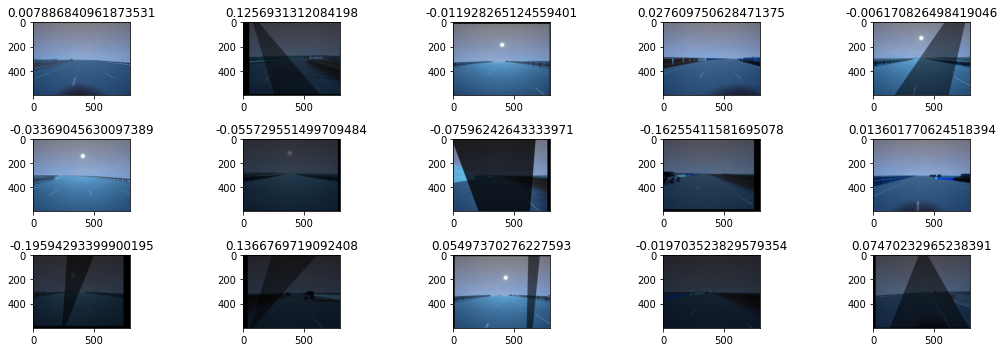

In [37]:
gen_val = generate_images(X_test, y_test, batch_size)
batch, steerings = next(gen_val)
show_images(batch[0:20], steerings[0:20])

In [42]:
predictions = np.array(m.predict(batch[0:20])).squeeze()
predictions = predictions.squeeze()


0.008945884183049202


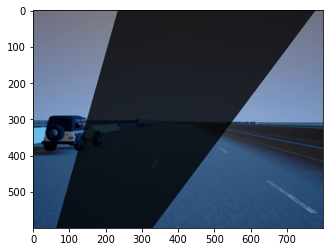

In [46]:
plt.imshow(batch[15])
print(steerings[15])

In [50]:
target_img = np.expand_dims(batch[15], 0)
np.shape(target_img)

(1, 600, 800, 3)

In [51]:
m.predict(target_img)

array([[-0.01061561]], dtype=float32)